# 1. Load & clean the World Bank CSV (make it usable)

In [ ]:
# Load and tidy World Bank inflation CSV for India
import pandas as pd
from pathlib import Path

DATA_DIR = Path("..") / "data"
INFLATION_RAW = DATA_DIR / "india_inflation.csv"
OUT_CLEAN = DATA_DIR / "india_inflation_clean.csv"

# 1. Read CSV skipping metadata rows (World Bank files have 4 lines of metadata before the header)
df_raw = pd.read_csv(INFLATION_RAW, skiprows=4, encoding='utf-8')

# 2. Confirm header loaded
print("Columns loaded (first 10):", list(df_raw.columns)[:10])

# 3. Select India row
india_row = df_raw[df_raw['Country Name'].str.strip().str.lower() == 'india']
if india_row.shape[0] != 1:
    raise SystemExit("Could not find exactly one India row — inspect your CSV manually.")
    
# 4. Drop metadata columns and convert year columns from wide → long
# Columns like '1960','1961',... are the year columns. We'll melt them.
year_cols = [c for c in df_raw.columns if c.isdigit()]   # picks '1960','1961',...
india_t = india_row.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
    value_vars=year_cols,
    var_name='year',
    value_name='cpi_index'
).reset_index(drop=True)

# 5. Cleanup types: year -> int, cpi_index -> float (coerce strange/missing values)
india_t['year'] = india_t['year'].astype(int)
india_t['cpi_index'] = pd.to_numeric(india_t['cpi_index'], errors='coerce')

# 6. Sort and compute inflation = % change of CPI index year-on-year
india_t = india_t.sort_values('year').reset_index(drop=True)
india_t['inflation_pct'] = india_t['cpi_index'].pct_change() * 100  # percent
india_t['inflation_pct'] = india_t['inflation_pct'].round(2)

# 7. Keep only useful cols
india_t = india_t[['year','cpi_index','inflation_pct']]

# 8. Save cleaned CSV for later use
india_t.to_csv(OUT_CLEAN, index=False)
print("Saved cleaned India CPI to:", OUT_CLEAN)
india_t.tail(10)

Columns loaded (first 10): ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965']
Saved cleaned India CPI to: ..\data\india_inflation_clean.csv


,year,cpi_index,inflation_pct
55,2015,4.906973,-26.38
56,2016,4.948216,0.84
57,2017,3.328173,-32.74
58,2018,3.938826,18.35
59,2019,3.729506,-5.31
60,2020,6.623437,77.60
61,2021,5.131407,-22.53
62,2022,6.699034,30.55
63,2023,5.649143,-15.67
64,2024,4.953036,-12.32


# 2) Inspect the spending dataset (very important — it might be missing headers)


In [3]:
# Inspect spending.csv structure safely
SP_FILE = DATA_DIR / "spending.csv"
print("Exists:", SP_FILE.exists())

# Show raw text first 5 lines to detect header issues
with open(SP_FILE, 'r', encoding='utf-8', errors='replace') as f:
    for i in range(8):
        print(i+1, f.readline().rstrip())

# Try to load with pandas default header detection (if header present)
try:
    sp_preview = pd.read_csv(SP_FILE, nrows=5)
    print("\nPandas-detected columns:", list(sp_preview.columns))
    display(sp_preview)
except Exception as e:
    print("Pandas couldn’t read standardly (error):", e)
    # try reading without header
    sp_preview_noheader = pd.read_csv(SP_FILE, header=None, nrows=5)
    print("\nFirst rows (no header):")
    display(sp_preview_noheader)


Exists: True
1 Income,Age,Dependents,Occupation,City_Tier,Rent,Loan_Repayment,Insurance,Groceries,Transport,Eating_Out,Entertainment,Utilities,Healthcare,Education,Miscellaneous,Desired_Savings_Percentage,Desired_Savings,Disposable_Income,Potential_Savings_Groceries,Potential_Savings_Transport,Potential_Savings_Eating_Out,Potential_Savings_Entertainment,Potential_Savings_Utilities,Potential_Savings_Healthcare,Potential_Savings_Education,Potential_Savings_Miscellaneous
2 44637.24964,49,0,Self_Employed,Tier_1,13391.17489,0,2206.490129,6658.768341,2636.970696,1651.801726,1536.184255,2911.792231,1546.914539,0,831.5251202,13.89094813,6200.537192,11265.62771,1685.696222,328.8952812,465.7691724,195.1513197,678.2928589,67.68247059,0,85.73551673
3 26858.59659,34,2,Retired,Tier_2,5371.719318,0,869.522617,2818.44446,1543.018778,649.3781027,1050.241738,1626.143346,1137.351325,1551.723167,564.2350071,7.160375738,1923.176434,9676.818733,540.306561,119.3471393,141.8660892,234.1311677,286.6684081,6.60

,Income,Age,Dependents,Occupation,City_Tier,Rent,Loan_Repayment,Insurance,Groceries,Transport,...,Desired_Savings,Disposable_Income,Potential_Savings_Groceries,Potential_Savings_Transport,Potential_Savings_Eating_Out,Potential_Savings_Entertainment,Potential_Savings_Utilities,Potential_Savings_Healthcare,Potential_Savings_Education,Potential_Savings_Miscellaneous
0,44637.24964,49,0,Self_Employed,Tier_1,13391.174890,0.000000,2206.490129,6658.768341,2636.970696,...,6200.537192,11265.627710,1685.696222,328.895281,465.769172,195.151320,678.292859,67.682471,0.000000,85.735517
1,26858.59659,34,2,Retired,Tier_2,5371.719318,0.000000,869.522617,2818.444460,1543.018778,...,1923.176434,9676.818733,540.306561,119.347139,141.866089,234.131168,286.668408,6.603212,56.306874,97.388606
2,50367.60508,35,1,Student,Tier_3,7555.140763,4612.103386,2201.800050,6313.222081,3221.396403,...,7050.360422,13891.450620,1466.073984,473.549752,410.857129,459.965257,488.383423,7.290892,106.653597,138.542422
3,101455.60020,21,0,Self_Employed,Tier_3,15218.340040,6809.441427,4889.418087,14690.149360,7106.130005,...,16694.965140,31617.953610,1875.932770,762.020789,1241.017448,320.190594,1389.815033,193.502754,0.000000,296.041183
4,24875.28355,52,4,Professional,Tier_2,4975.056710,3112.609398,635.907170,3034.329665,1276.155163,...,1874.099434,6265.700532,788.953124,68.160766,61.712505,187.173750,194.117130,47.294591,67.388120,96.557076


In [8]:
# Load the spending dataset cleanly
spending = pd.read_csv(SP_FILE)

# Quick check of shape and columns
print("Spending shape:", spending.shape)
print("First 10 columns:", list(spending.columns[:10]))

# Peek at first few rows
spending.head()

Spending shape: (20000, 27)
First 10 columns: ['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries', 'Transport']


,Income,Age,Dependents,Occupation,City_Tier,Rent,Loan_Repayment,Insurance,Groceries,Transport,...,Desired_Savings,Disposable_Income,Potential_Savings_Groceries,Potential_Savings_Transport,Potential_Savings_Eating_Out,Potential_Savings_Entertainment,Potential_Savings_Utilities,Potential_Savings_Healthcare,Potential_Savings_Education,Potential_Savings_Miscellaneous
0,44637.24964,49,0,Self_Employed,Tier_1,13391.174890,0.000000,2206.490129,6658.768341,2636.970696,...,6200.537192,11265.627710,1685.696222,328.895281,465.769172,195.151320,678.292859,67.682471,0.000000,85.735517
1,26858.59659,34,2,Retired,Tier_2,5371.719318,0.000000,869.522617,2818.444460,1543.018778,...,1923.176434,9676.818733,540.306561,119.347139,141.866089,234.131168,286.668408,6.603212,56.306874,97.388606
2,50367.60508,35,1,Student,Tier_3,7555.140763,4612.103386,2201.800050,6313.222081,3221.396403,...,7050.360422,13891.450620,1466.073984,473.549752,410.857129,459.965257,488.383423,7.290892,106.653597,138.542422
3,101455.60020,21,0,Self_Employed,Tier_3,15218.340040,6809.441427,4889.418087,14690.149360,7106.130005,...,16694.965140,31617.953610,1875.932770,762.020789,1241.017448,320.190594,1389.815033,193.502754,0.000000,296.041183
4,24875.28355,52,4,Professional,Tier_2,4975.056710,3112.609398,635.907170,3034.329665,1276.155163,...,1874.099434,6265.700532,788.953124,68.160766,61.712505,187.173750,194.117130,47.294591,67.388120,96.557076


# 4. Explore & Understand the Spending Datase

In [9]:
# 1. Basic info (columns, dtypes, non-null counts)
print("\n--- Info ---")
spending.info()

# 2. Quick stats (only numeric columns)
print("\n--- Describe numeric ---")
display(spending.describe().T)

# 3. Quick stats (categorical/object columns)
print("\n--- Categorical columns (value counts for first few) ---")
for col in spending.select_dtypes(include='object').columns[:5]:  # just preview first 5 categoricals
    print(f"\n{col} → top values:")
    print(spending[col].value_counts().head())


--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Income                           20000 non-null  float64
 1   Age                              20000 non-null  int64  
 2   Dependents                       20000 non-null  int64  
 3   Occupation                       20000 non-null  object 
 4   City_Tier                        20000 non-null  object 
 5   Rent                             20000 non-null  float64
 6   Loan_Repayment                   20000 non-null  float64
 7   Insurance                        20000 non-null  float64
 8   Groceries                        20000 non-null  float64
 9   Transport                        20000 non-null  float64
 10  Eating_Out                       20000 non-null  float64
 11  Entertainment                    20000 non-null  float64
 12  Util

,count,mean,std,min,25%,50%,75%,max
Income,20000.0,41585.496104,40014.540538,1301.187333,17604.875958,30185.383480,51765.446463,1.079728e+06
Age,20000.0,41.031450,13.578725,18.000000,29.000000,41.000000,53.000000,6.400000e+01
Dependents,20000.0,1.995950,1.417616,0.000000,1.000000,2.000000,3.000000,4.000000e+00
Rent,20000.0,9115.494629,9254.228188,235.365692,3649.422245,6402.751824,11263.940490,2.159457e+05
Loan_Repayment,20000.0,2049.800292,4281.789941,0.000000,0.000000,0.000000,2627.142320,1.230807e+05
Insurance,20000.0,1455.028761,1492.938435,30.002012,580.204749,1017.124681,1787.160895,3.873493e+04
Groceries,20000.0,5205.667493,5035.953689,154.078240,2165.426419,3741.091534,6470.892718,1.198169e+05
Transport,20000.0,2704.466685,2666.345648,81.228584,1124.578013,1933.845509,3360.597508,8.186150e+04
Eating_Out,20000.0,1461.856982,1481.660811,39.437523,581.011801,1029.109727,1807.075251,3.440610e+04
Entertainment,20000.0,1448.853658,1489.019270,45.421469,581.632906,1020.198375,1790.104081,3.866737e+04



--- Categorical columns (value counts for first few) ---

Occupation → top values:
Occupation
Retired          5019
Professional     5011
Student          5003
Self_Employed    4967
Name: count, dtype: int64

City_Tier → top values:
City_Tier
Tier_2    10068
Tier_1     5934
Tier_3     3998
Name: count, dtype: int64


# 5 – Aggregate Household Spending into Yearly Averages


In [10]:
# 1. Select spending-related columns (exclude Income/Age/Occupation/etc.)
spending_cols = [
    'Groceries','Transport','Education','Healthcare','Entertainment',
    'Utilities','Insurance','Rent','Eating_Out','Loan_Repayment'
]

# 2. Compute mean spending across all households
spending_avg = spending[spending_cols].mean().reset_index()
spending_avg.columns = ['category', 'avg_monthly_spending']

# 3. Convert to yearly spending (12 months)
spending_avg['avg_yearly_spending'] = spending_avg['avg_monthly_spending'] * 12

print("\n--- Average yearly spending per category (all households) ---")
display(spending_avg)



--- Average yearly spending per category (all households) ---


,category,avg_monthly_spending,avg_yearly_spending
0,Groceries,5205.667493,62468.009915
1,Transport,2704.466685,32453.600221
2,Education,2498.348422,29980.181058
3,Healthcare,1663.081794,19956.981530
4,Entertainment,1448.853658,17386.243891
5,Utilities,2504.976953,30059.723435
6,Insurance,1455.028761,17460.345126
7,Rent,9115.494629,109385.935546
8,Eating_Out,1461.856982,17542.283778
9,Loan_Repayment,2049.800292,24597.603499


# 6 – Align Spending with Inflation Data

The problem:

Inflation dataset → yearly, with year, cpi_index, inflation_pct.

Spending dataset → only one snapshot (no year column).

### A -  Load cleaned inflation dataset

In [13]:
# Load cleaned inflation data
inflation = pd.read_csv(DATA_DIR / "india_inflation_clean.csv")

print("\nInflation dataset (last 5 years):")
display(inflation.tail())



Inflation dataset (last 5 years):


,year,cpi_index,inflation_pct
60,2020,6.623437,77.60
61,2021,5.131407,-22.53
62,2022,6.699034,30.55
63,2023,5.649143,-15.67
64,2024,4.953036,-12.32


### B - Attach spending snapshot to the latest inflation year

In [14]:
# Attach spending to last inflation year

# Get latest year in inflation dataset
latest_year = inflation['year'].max()

# Add 'year' column to spending averages (all categories same year)
spending_avg['year'] = latest_year

print(f"\nAttached spending to year {latest_year}:")
display(spending_avg.head())



Attached spending to year 2024:


,category,avg_monthly_spending,avg_yearly_spending,year
0,Groceries,5205.667493,62468.009915,2024
1,Transport,2704.466685,32453.600221,2024
2,Education,2498.348422,29980.181058,2024
3,Healthcare,1663.081794,19956.981530,2024
4,Entertainment,1448.853658,17386.243891,2024


### Prepare for later merging

In [16]:
# Ready datasets for merge

# Inflation = yearly series
print("\nInflation columns:", inflation.columns.tolist())
print("Spending columns:", spending_avg.columns.tolist())



Inflation columns: ['year', 'cpi_index', 'inflation_pct']
Spending columns: ['category', 'avg_monthly_spending', 'avg_yearly_spending', 'year']


In [27]:
# Save cleaned spending dataset for dashboard use
spending_avg.to_csv(DATA_DIR / "spending_clean.csv", index=False)
print("Saved cleaned spending dataset!")


Saved cleaned spending dataset!


# 7 – Visualize Inflation + Spending
A line chart for inflation across time.

A bar chart for spending categories

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nice default theme
sns.set_theme(style="whitegrid")

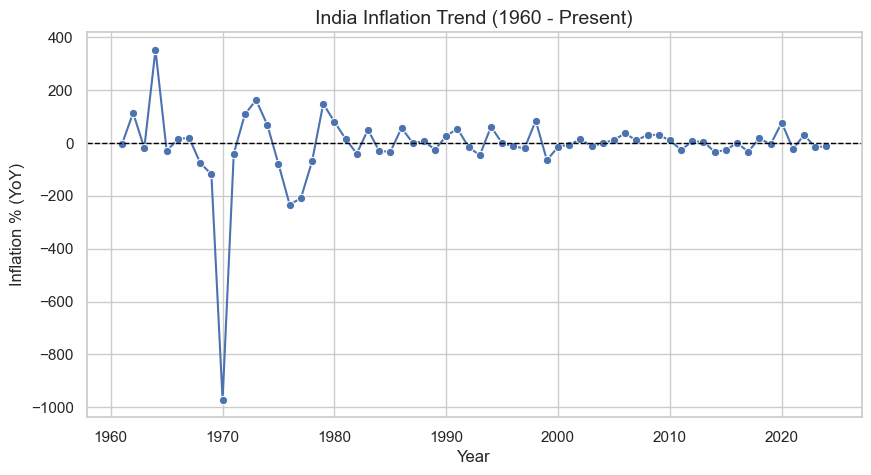

In [19]:
# Inflation trend over time
plt.figure(figsize=(10,5))
sns.lineplot(data=inflation, x="year", y="inflation_pct", marker="o")

plt.title("India Inflation Trend (1960 - Present)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Inflation % (YoY)")
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.show()


latest_year = 2024
spending_avg sample:


,category,avg_monthly_spending,avg_yearly_spending,year
0,Groceries,5205.667493,62468.009915,2024
1,Transport,2704.466685,32453.600221,2024
2,Education,2498.348422,29980.181058,2024
3,Healthcare,1663.081794,19956.981530,2024
4,Entertainment,1448.853658,17386.243891,2024



--- plot_df head and dtypes ---


,Category,Average Spending
0,category,Groceries
1,avg_monthly_spending,5205.667493
2,avg_yearly_spending,62468.009915


Category            object
Average Spending    object
dtype: object

--- After coercion dtypes ---
Category             object
Average Spending    float64
dtype: object


,Category,Average Spending
0,category,NaN
1,avg_monthly_spending,5205.667493
2,avg_yearly_spending,62468.009915


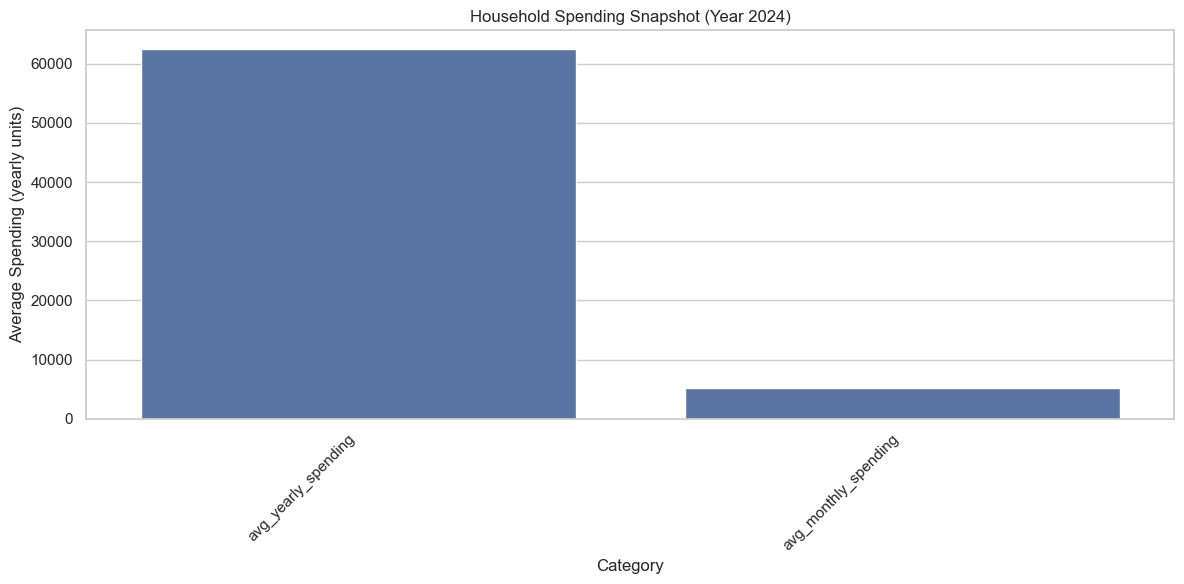

C:\Users\Owner\AppData\Local\Temp\ipykernel_10440\4282391478.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_df['Category'], rotation=45, ha='right')


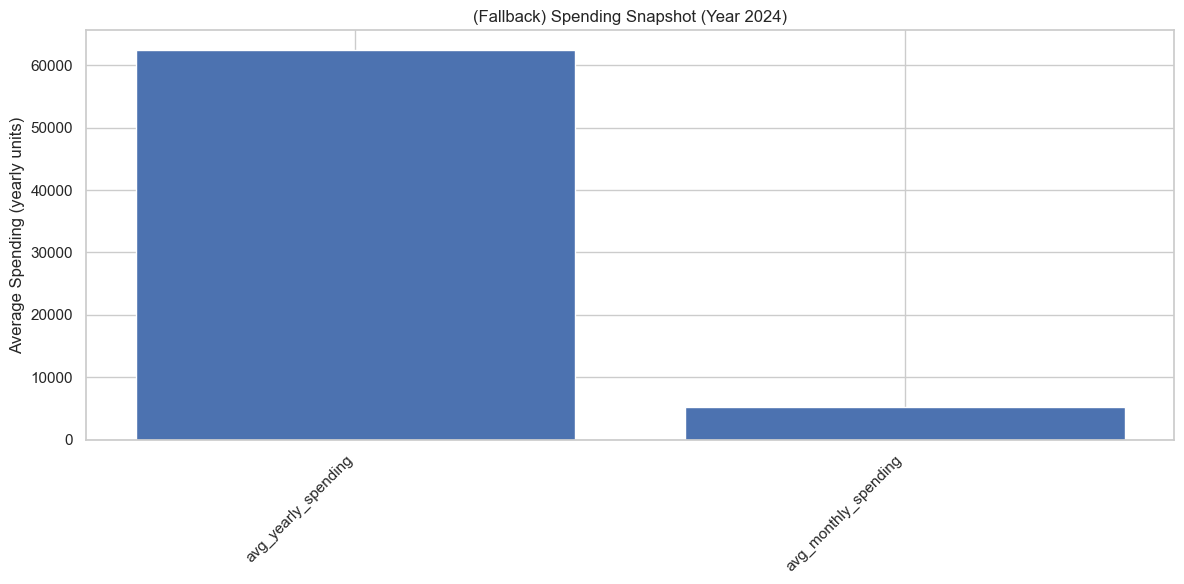

In [24]:
# Diagnostic + Robust plotting for spending snapshot

# assume latest_year and spending_avg exist from previous steps
print("latest_year =", latest_year)
print("spending_avg sample:")
display(spending_avg.head())

# 1) Get one-row for latest year (force one row)
spend_latest = spending_avg[spending_avg["year"] == latest_year].drop(columns="year").iloc[0:1]

# 2) Build plot_df: transpose so categories become rows
plot_df = spend_latest.T.reset_index()
plot_df.columns = ["Category", "Average Spending"]

# 3) Diagnostic prints
print("\n--- plot_df head and dtypes ---")
display(plot_df.head(20))
print(plot_df.dtypes)

# 4) Fix types explicitly
plot_df['Category'] = plot_df['Category'].astype(str)                     # ensure categories are strings
plot_df['Average Spending'] = pd.to_numeric(plot_df['Average Spending'], errors='coerce')  # ensure numeric

print("\n--- After coercion dtypes ---")
print(plot_df.dtypes)
display(plot_df)

# 5) Optional: drop rows with NaN spending
plot_df = plot_df.dropna(subset=['Average Spending']).copy()

# 6) Sort for nicer plot (largest first)
plot_df = plot_df.sort_values('Average Spending', ascending=False)

# 7) Plot with seaborn (categorical x)
plt.figure(figsize=(12,6))
sns.barplot(data=plot_df, x='Category', y='Average Spending')
plt.xticks(rotation=45, ha='right')
plt.title(f"Household Spending Snapshot (Year {latest_year})")
plt.ylabel("Average Spending (yearly units)")
plt.xlabel("Category")
plt.tight_layout()
plt.show()

# 8) If seaborn still errors for any reason, fallback to plain matplotlib:
if plot_df.shape[0] > 0:
    try:
        # quick fallback
        fig, ax = plt.subplots(figsize=(12,6))
        ax.bar(plot_df['Category'], plot_df['Average Spending'])
        ax.set_xticklabels(plot_df['Category'], rotation=45, ha='right')
        ax.set_title(f"(Fallback) Spending Snapshot (Year {latest_year})")
        ax.set_ylabel("Average Spending (yearly units)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Unexpected plotting error (fallback):", e)


# 8 – Inflation vs Spending Correlation


--- Inflation data sample ---


,year,cpi_index,inflation_pct
0,1960,1.779878,NaN
1,1961,1.695213,-4.76
2,1962,3.632215,114.26
3,1963,2.946161,-18.89
4,1964,13.355261,353.31



--- Spending data sample ---


,category,avg_monthly_spending,avg_yearly_spending,year
0,Groceries,5205.667493,62468.009915,2024
1,Transport,2704.466685,32453.600221,2024
2,Education,2498.348422,29980.181058,2024
3,Healthcare,1663.081794,19956.981530,2024
4,Entertainment,1448.853658,17386.243891,2024



--- Merged dataset sample ---


,category,avg_monthly_spending,avg_yearly_spending,year,cpi_index,inflation_pct
0,Groceries,5205.667493,62468.009915,2024,4.953036,-12.32
1,Transport,2704.466685,32453.600221,2024,4.953036,-12.32
2,Education,2498.348422,29980.181058,2024,4.953036,-12.32
3,Healthcare,1663.081794,19956.981530,2024,4.953036,-12.32
4,Entertainment,1448.853658,17386.243891,2024,4.953036,-12.32



--- Correlation matrix ---


,avg_monthly_spending,avg_yearly_spending,year,cpi_index,inflation_pct
avg_monthly_spending,1.0,1.0,NaN,NaN,NaN
avg_yearly_spending,1.0,1.0,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN
cpi_index,NaN,NaN,NaN,NaN,NaN
inflation_pct,NaN,NaN,NaN,NaN,NaN


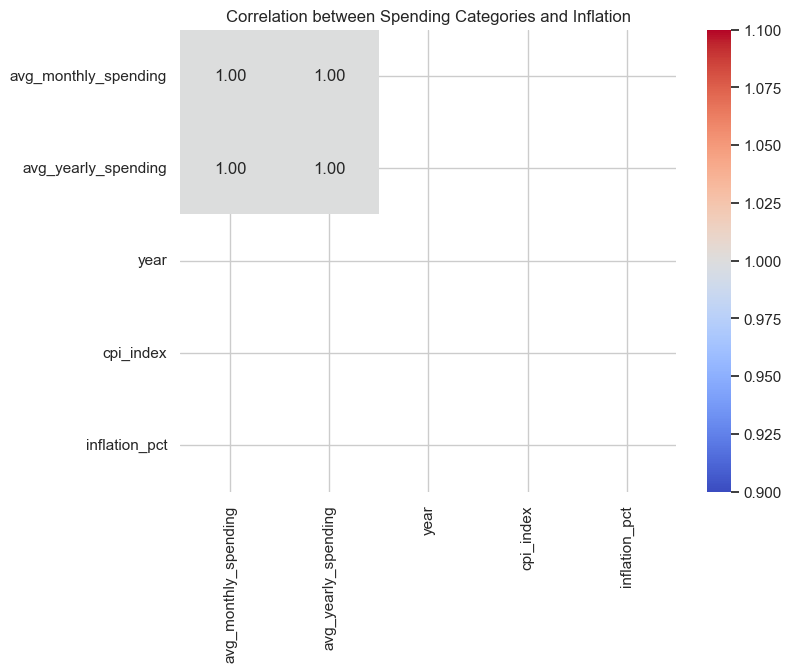

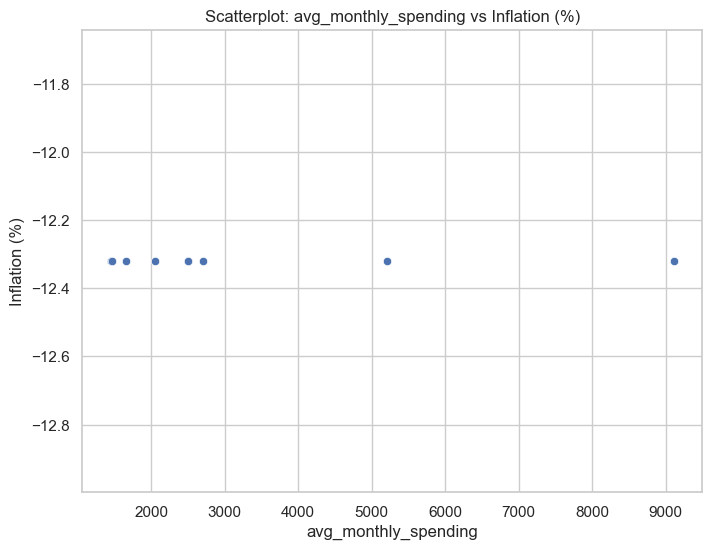

In [26]:
# Phase 8: Correlation between inflation and spending

# 1. Load cleaned inflation dataset
inflation = pd.read_csv(DATA_DIR / "india_inflation_clean.csv")

print("\n--- Inflation data sample ---")
display(inflation.head())

print("\n--- Spending data sample ---")
display(spending_avg.head())

# 2. Merge spending averages with inflation on 'year'
merged = pd.merge(spending_avg, inflation, on="year", how="inner")

print("\n--- Merged dataset sample ---")
display(merged.head())

# 3. Correlation matrix
corr = merged.corr(numeric_only=True)

print("\n--- Correlation matrix ---")
display(corr)

# 4. Heatmap of correlations
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Spending Categories and Inflation")
plt.show()

# 5. Example: scatterplot inflation vs one spending category
example_col = merged.columns[1]   # pick the first spending category
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x=example_col, y="inflation_pct")
plt.title(f"Scatterplot: {example_col} vs Inflation (%)")
plt.xlabel(example_col)
plt.ylabel("Inflation (%)")
plt.show()

